In [4]:
import os
import random
from glob import glob
import pydicom
import SimpleITK as sitk
from tqdm import tqdm
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
import albumentations as A

from skimage import io, transform
from skimage.transform import resize

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [1]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pydicom
import cv2
import pandas as pd
from scipy.ndimage import zoom

import numpy as np

def apply_windowing(image, window_center, window_width):
    # Convert to float for precision
    image = image.astype(np.float32)

    # Calculate the lower and upper bounds
    lower_bound = window_center - (window_width / 2)
    upper_bound = window_center + (window_width / 2)

    # Apply windowing
    windowed_image = np.clip(image, lower_bound, upper_bound)
    
    ### Set to maxpixel
    windowed_image = ((windowed_image - lower_bound) / (upper_bound - lower_bound)) * 4095.0

    return windowed_image.astype(np.float32)


def resample_img(itk_image, out_spacing=[1.0, 1.0, 1.0], is_label=True):
    
    # Resample images to 2mm spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
#         int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))
        1
    ]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    itk = resample.Execute(itk_image)
    
    image = np.array(sitk.GetArrayFromImage(itk)) ## CxHxW
    image = np.moveaxis(image, 0, -1) ## HxWx1
    
    return image 


def position_finder(pos):
        pos = list(np.round(pos))
        if pos == [1.0 , 0.0 ,0.0 ,0.0, 0.0, -1.0]:
            return 'Coronal'
        elif pos == [0.0 , 1.0 ,0.0 ,0.0, 0.0, -1.0]:
            return 'Sagittal'
        elif pos == [1.0 , 0.0 ,0.0 ,0.0, 1.0, 0.0]:
            return 'Axial'
        else:
            print(pos)
            return 'None'
        
def Type_Axial_filter(path,label_path):
    Type = []
    Position = []
    df = pd.read_csv(label_path)
    for i in df['SeriesInstanceUID']:
        SerisPath = os.path.join(path,i)
        SamplePath = os.path.join(SerisPath,os.listdir(SerisPath)[0])
        Sample = pydicom.dcmread(SamplePath)
        Position.append(position_finder(Sample.ImageOrientationPatient))
        Type.append(Sample.SeriesDescription)
        
    df['Orientation']= Position
    df['Modality']= Type
    
    return df


class MRIDataset(Dataset):
    def __init__(self, root_img, labelPath, transform=None, Interpolation = False, pad=False,
                 Filter_Axial=True,Filter_type =False,balanced = False):
        
        self.root_img = root_img
        self.transform = transform
        self.Interpolation = Interpolation
        self.pad = pad
        self.label = Type_Axial_filter(root_img,labelPath)
        if Filter_Axial:
            self.label = self.label[self.label['Orientation']=='Axial']
        if Filter_type:
            self.label = self.label[self.label['Modality']== Filter_type]
            self.num_anbnormal = self.label[self.label['prediction']==1].shape[0]
        else:
            self.num_anbnormal = self.label[self.label['prediction']==1].shape[0]
            
        if balanced:
            self.label = pd.concat([self.label[self.label['prediction']==1],
                                    self.label[self.label['prediction']==0].iloc[:self.num_anbnormal]])
        
        self.image_paths = []
        self.labels = []

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        label = self.label.iloc[idx]['prediction']
        patient_path = os.path.join(self.root_img, self.label.iloc[idx]['SeriesInstanceUID'])
        
        if self.Interpolation:
            images = self.interpolate_slices(self.read_dicom(patient_path),20)
            images = np.array(images,dtype=np.float32)
#             images = images / images.max()
        elif self.pad:
            images = np.stack(self.read_dicom(patient_path),axis = 0, dtype=np.float32)
#             images = images / images.max()
            images = self.padding(images)
        else:
            images = np.stack(self.read_dicom(patient_path),axis = 0, dtype=np.float32)
#             images = images / images.max()
            
            
        images = torch.from_numpy(images)
        
        if self.transform:
            images = self.transform(images)
        
        return images, label.astype(np.float32)
    
    
#     def read_dicom(self,path):
#         dicom_files = [pydicom.dcmread(os.path.join(path, f)) for f in os.listdir(path) if f.endswith('.dcm')]
        
#         itk_files = [sitk.ReadImage(os.path.join(path, f)) for f in os.listdir(path) if f.endswith('.dcm')]
        
#         dicom_files_with_location = []
        
#         for dicom_file in dicom_files:
#             try:
#                 location = self.get_slice_location(dicom_file)
#                 dicom_files_with_location.append((location, dicom_file))
#             except ValueError as e:
#                 print(e)
                
#         dicom_files_with_location.sort(key=lambda x: x[0])
# #         sorted_dicom_files = [cv2.resize(file.pixel_array,(128,128)) for _, file in dicom_files_with_location]
#         sorted_dicom_files = [apply_windowing(cv2.resize(file.pixel_array,(128,128)), file.WindowCenter, file.WindowWidth) for _, file in dicom_files_with_location]

#         return sorted_dicom_files
    
    def read_dicom(self,path):
        dicom_files = [(pydicom.dcmread(os.path.join(path, f)), sitk.ReadImage(os.path.join(path, f))) for f in os.listdir(path) if f.endswith('.dcm')]
                
        dicom_files_with_location = []
        
        for dicom_file in dicom_files:
            try:
                location = self.get_slice_location(dicom_file[0])
                dicom_files_with_location.append((location, dicom_file))
            except ValueError as e:
                print(e)
                
        dicom_files_with_location.sort(key=lambda x: x[0])
        sorted_dicom_files=[]
        for _, (ds, itk_img) in dicom_files_with_location:
            image = resample_img(itk_img, out_spacing=(1,1,1))  ### Cubic
            image = cv2.resize(image, (128, 128), interpolation=cv2.INTER_CUBIC)
            window_image = apply_windowing(image,  ds.WindowCenter, ds.WindowWidth)
            sorted_dicom_files.append(window_image)
        
        return sorted_dicom_files
                
    def get_slice_location(self,dicom_data):
        """
        Extracts the slice location from a DICOM file.
        """
        # Try to get the SliceLocation attribute first, fallback to ImagePositionPatient if unavailable
        try:
            return dicom_data.SliceLocation
        except AttributeError:
            try:
                return dicom_data.ImagePositionPatient[2]  # Assuming axial slices, z-coordinate
            except AttributeError:
                raise ValueError(f"Cannot determine slice location for file: {dicom_data}")
    
    def interpolate_slices(self,dicom_series, target_num_slices):
        image_data = np.stack(dicom_series, axis=0)
        original_num_slices = image_data.shape[0]
        zoom_factors = [target_num_slices / original_num_slices] + [1] * (image_data.ndim - 1)
        interpolated_data = zoom(image_data, zoom_factors, order=1)  # Linear interpolation
        return interpolated_data
    
    def padding(self,dicoms_file):
        m,n,k = dicoms_file.shape
        pad = np.zeros((20-m,n,k))
        return np.concatenate((dicoms_file,pad),axis=0)
    
    

In [2]:
dataset = MRIDataset(root_img='/kaggle/input/iaaa-mri-challenge/data',
                          labelPath='/kaggle/input/iaaa-mri-challenge/train.csv',
                          transform=None, Interpolation = True, pad=False,
                          Filter_Axial=True,Filter_type ='T1W_SE',balanced = False)

[1.0, 0.0, 0.0, -0.0, 1.0, -1.0]
[1.0, 0.0, 0.0, -0.0, 1.0, -1.0]
[1.0, 0.0, 0.0, -0.0, 1.0, -1.0]
[1.0, 0.0, 0.0, 0.0, 1.0, -1.0]
[1.0, 0.0, 0.0, 0.0, 1.0, -1.0]
[1.0, 0.0, 0.0, 0.0, 1.0, -1.0]
[1.0, 0.0, 0.0, 0.0, 1.0, -1.0]
[1.0, 0.0, 0.0, 0.0, 1.0, -1.0]
[1.0, 0.0, 0.0, 0.0, 1.0, -1.0]
[1.0, 0.0, 0.0, 0.0, 1.0, -1.0]
[1.0, 0.0, 0.0, 0.0, 1.0, -1.0]
[1.0, 0.0, 0.0, 0.0, 1.0, -1.0]
[1.0, 0.0, 0.0, -0.0, 1.0, -1.0]
[1.0, 0.0, 0.0, -0.0, 1.0, -1.0]
[1.0, 0.0, 0.0, -0.0, 1.0, -1.0]
[1.0, 0.0, -0.0, -0.0, 1.0, -1.0]
[1.0, 0.0, -0.0, -0.0, 1.0, -1.0]
[1.0, 0.0, -0.0, -0.0, 1.0, -1.0]


In [8]:
import time
start_time = time.time()

train_loader = torch.utils.data.DataLoader(dataset, batch_size=3, shuffle=False)  
bx, by = next(iter(train_loader))

print("--- %s seconds ---" % (time.time() - start_time))

--- 2.948617458343506 seconds ---


In [9]:
bx=bx.numpy()
by=by.numpy()

bx = np.expand_dims(bx, axis=-1)
by = np.expand_dims(by, axis=-1)

In [10]:
bx.shape

(3, 20, 128, 128, 1)

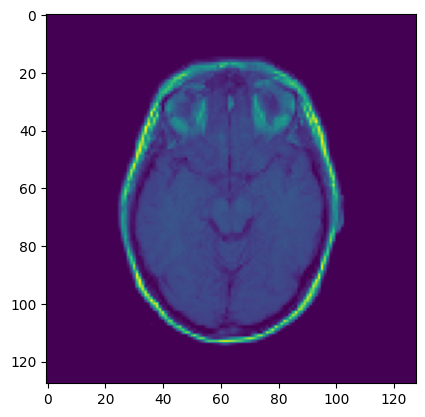

In [8]:
plt.imshow(bx[0][7])

In [2]:
def resample_img(itk_image, out_spacing=[1.0, 1.0, 1.0], is_label=True):
    
    # Resample images to 2mm spacing with SimpleITK
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))
    ]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    itk = resample.Execute(itk_image)
    
    image = np.array(sitk.GetArrayFromImage(itk)) ## CxHxW
    image = np.moveaxis(image, 0, -1) ## HxWx1
    
    return image 

In [43]:
address = '/kaggle/input/iaaa-mri-challenge/data'
listdirs = glob(address + "/*")
files = glob(listdirs[-500]+"/*")
lst=[]
for file in files:
    itk_image = sitk.ReadImage(file)
#     print(itk_image.GetSpacing())
    img = np.array(sitk.GetArrayFromImage(itk_image))
    img = np.moveaxis(img, 0, -1)
    
    img = np.expand_dims(img, axis=0) ## 1xHxWx1
    lst.append(img.astype(np.float32))
    
tensor = np.concatenate(lst, axis=0)
tensor.shape

(16, 256, 256, 1)

In [45]:
file

'/kaggle/input/iaaa-mri-challenge/data/1.3.46.670589.11.10042.5.0.5328.2024011012531898768/1.3.46.670589.11.10042.5.0.5328.2024011012543095798.dcm'

In [26]:
address = '/kaggle/input/iaaa-mri-challenge/data'
listdirs = glob(address + "/*")
files = glob(listdirs[5]+"/*")

itk_image = sitk.ReadImage(files[0])
out_spacing = (1,1,1) # Example spacing

original_spacing = itk_image.GetSpacing()
original_size = itk_image.GetSize()

out_size = [
    int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
    int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
#     int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))
    1
]

resample = sitk.ResampleImageFilter()
resample.SetOutputSpacing(out_spacing)
resample.SetSize(out_size)
resample.SetOutputDirection(itk_image.GetDirection())
resample.SetOutputOrigin(itk_image.GetOrigin())
resample.SetTransform(sitk.Transform())
resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

if True:
    resample.SetInterpolator(sitk.sitkNearestNeighbor)
else:
    resample.SetInterpolator(sitk.sitkBSpline)

resampled_image = resample.Execute(itk_image)
rimg = np.array(sitk.GetArrayFromImage(resampled_image))
rimg = np.moveaxis(rimg, 0, -1)

print('resampled image size:', rimg.shape)
out_size

resampled image size: (240, 240, 1)


[240, 240, 1]

In [15]:
img = np.array(sitk.GetArrayFromImage(itk_image))

In [16]:
img.shape

(1, 288, 288)

In [24]:
np.sum(rimg[...,0]==rimg[...,1])

57600

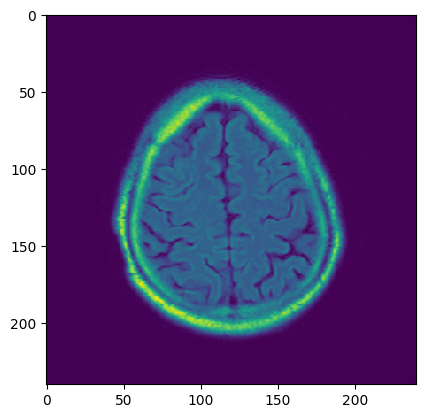

In [21]:
plt.imshow(rimg[...,0])

In [22]:
import random 
root_dir = '/kaggle/input/iaaa-mri-challenge/data/'

df = pd.read_csv('/kaggle/input/iaaa-mri-challenge/train.csv')

abnormal_cases = list(df[df.prediction==1]['SeriesInstanceUID'])
abnormal_cases_T1 = [id for id in abnormal_cases if pydicom.dcmread(glob(root_dir+id+'/*')[0]).SeriesDescription=='T1W_SE']

normal_cases = list(df[df.prediction==0]['SeriesInstanceUID'])
normal_cases_T1 = [id for id in normal_cases if pydicom.dcmread(glob(root_dir+id+'/*')[0]).SeriesDescription=='T1W_SE']

In [11]:
'''Load Entire dataset in a RAM'''
import time
start_time = time.time()

T1_files_path = normal_cases_T1[:100] + abnormal_cases_T1[:15]
image_size=256
batch_array_list=[]
batch_target_list=[]

for id in T1_files_path:
    ## target
    target = df[df['SeriesInstanceUID']== id].prediction
    target = np.array(target, dtype=np.float32)
    ## Dicoms
    files_path = glob(root_dir+id+'/*')
    sorted_dicoms = dict(sorted((pydicom.dcmread(file).SliceLocation, file) for file in files_path))
    array_list=[]
    
    for file_path in sorted_dicoms.values():
        ds = pydicom.dcmread(file_path)
        image = sitk.ReadImage(file_path)
        image = resample_img(image, out_spacing=(0.5,0.5,0.5))  ### Cubic
        image = np.array(sitk.GetArrayFromImage(image)) ## CxHxW
        image = np.mean(image, axis=0) ## HxW  ----------->>>>> Averaging on channel 'C'
#         image = np.moveaxis(image, 0, -1) ## HxWx1
        image = cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_CUBIC)
        
        image = np.expand_dims(image, axis=-1) ## HxWx1
        
#         image = image/np.max(image)  ## normalize
        image = np.expand_dims(image, axis=0) ## 1xHxWx1
        array_list.append(image.astype(np.float32))

    k=20
    if len(array_list)<k:
        arrays = np.concatenate(array_list, axis=0)
        zeros = np.zeros(shape=(k-len(array_list),image_size,image_size,1)).astype(np.float32)
        array = np.concatenate((arrays, zeros), axis=0) ##padding the array
    elif len(array_list)==k:
        array = np.concatenate(array_list, axis=0)
    else:
        array = np.concatenate(array_list[:k], axis=0)

    batch_array_list.append(np.expand_dims(array, axis=0)) ## 1x20xHxWx1
    batch_target_list.append(target)

## Final input and output  
batch_array = np.concatenate(batch_array_list, axis=0)
batch_target = np.array(batch_target_list) ## (1044, 128,128,1)

print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

In [25]:
np.save('/kaggle/working/batch_array.npy', batch_array)
np.save('/kaggle/working/bacth_target.npy', batch_target)

In [9]:
batch_target=by
batch_array=bx

In [45]:
'''SMOTE'''
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE
from imblearn.combine import SMOTEENN

B=batch_array.shape[0]
T=batch_array.shape[1]
H=batch_array.shape[2]
W=batch_array.shape[3]
C=batch_array.shape[4]

print('Original dataset shape %s' % Counter(np.squeeze(batch_target, axis=-1)))
# sm = SMOTE(random_state=42)
sm = BorderlineSMOTE(random_state=42)
# sm = SMOTEENN(random_state=42)
X_resampled, y_resampled = sm.fit_resample(batch_array.reshape(B, T*H*W*C), batch_target)

print('Resampled dataset shape %s' % Counter(y_resampled))

Original dataset shape Counter({0.0: 908, 1.0: 122})
Resampled dataset shape Counter({0.0: 908, 1.0: 908})


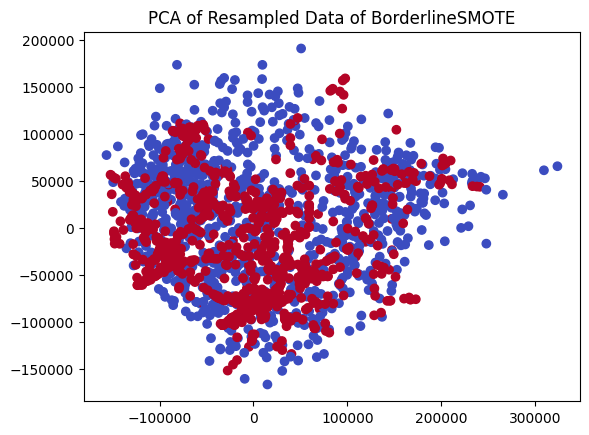

In [46]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# X_resampled = batch_array.reshape(B, T*H*W*C)
# y_resampled = batch_target

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Plot the PCA results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_resampled, cmap='coolwarm')
plt.title('PCA of Resampled Data of BorderlineSMOTE')
plt.show()


In [10]:
'''SVMSMOTE'''
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, SVMSMOTE

B=batch_array.shape[0]
T=batch_array.shape[1]
H=batch_array.shape[2]
W=batch_array.shape[3]
C=batch_array.shape[4]

print('Original dataset shape %s' % Counter(np.squeeze(batch_target, axis=-1)))
sm = SVMSMOTE(random_state=42, m_neighbors=10)
X_resampled, y_resampled = sm.fit_resample(batch_array.reshape(B, T*H*W*C), batch_target)

print('Resampled dataset shape %s' % Counter(y_resampled))



Original dataset shape Counter({0.0: 908, 1.0: 122})
Resampled dataset shape Counter({0.0: 908, 1.0: 908})


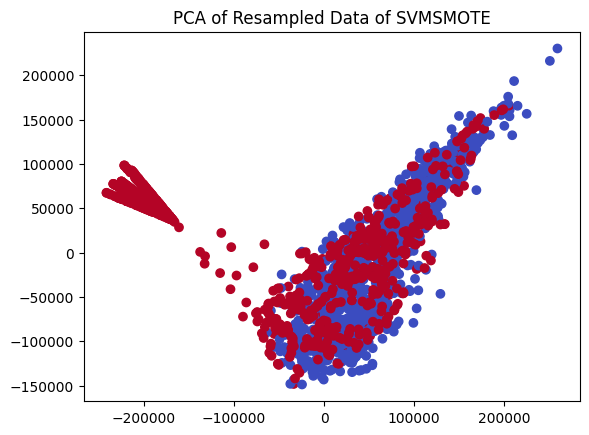

In [11]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# X_resampled = batch_array.reshape(B, T*H*W*C)
# y_resampled = batch_target

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Plot the PCA results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_resampled, cmap='coolwarm')
plt.title('PCA of Resampled Data of SVMSMOTE')
plt.show()


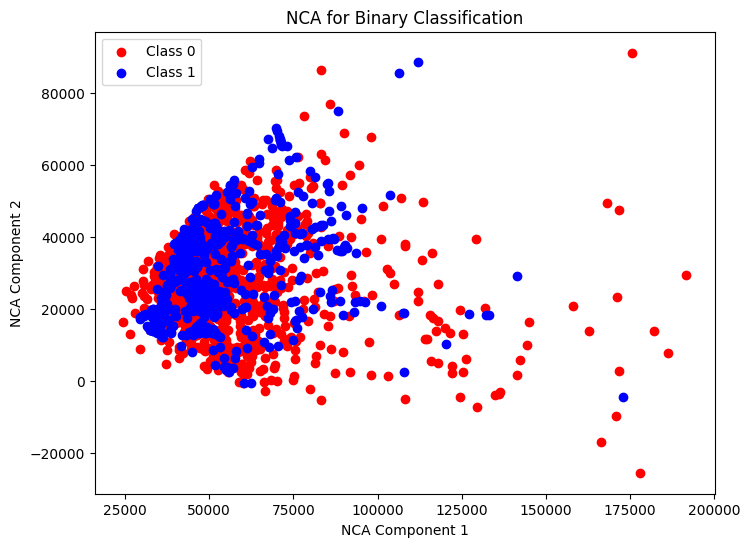

In [61]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt


# Initialize the NCA model
nca = NeighborhoodComponentsAnalysis(n_components=2, random_state=42)

# Initialize a k-nearest neighbors classifier
knn = KNeighborsClassifier(n_neighbors=3)

# Create a pipeline that first applies NCA and then fits a kNN classifier
nca_knn_pipeline = Pipeline([('nca', nca), ('knn', knn)])

# Fit the pipeline to the training data
nca_knn_pipeline.fit(X_resampled, y_resampled)

# Transform the data using the fitted NCA model for visualization
X_nca = nca.transform(X_resampled)

# Plot the result
plt.figure(figsize=(8, 6))
for i, color, label in zip([0, 1], ['red', 'blue'], ['Class 0', 'Class 1']):
    plt.scatter(X_nca[y_resampled == i, 0], X_nca[y_resampled == i, 1], color=color, label=label)
    
plt.title("NCA for Binary Classification")
plt.xlabel("NCA Component 1")
plt.ylabel("NCA Component 2")
plt.legend(loc='best')
plt.show()


/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


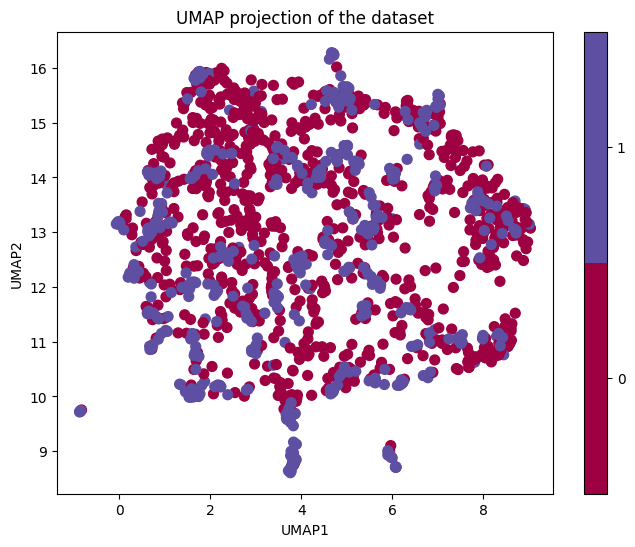

In [62]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Initialize UMAP with desired parameters
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

# Fit and transform the data
X_umap = umap_reducer.fit_transform(X_resampled)

# Plotting the results
plt.figure(figsize=(8, 6))
plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y_resampled, cmap='Spectral', s=50)
plt.colorbar(boundaries=np.arange(3)-0.5).set_ticks([0, 1])  # Adjust based on the number of classes
plt.title('UMAP projection of the dataset')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()


In [12]:
'''ADASYN'''
from collections import Counter
from imblearn.over_sampling import ADASYN

B=batch_array.shape[0]
T=batch_array.shape[1]
H=batch_array.shape[2]
W=batch_array.shape[3]
C=batch_array.shape[4]

print('Original dataset shape %s' % Counter(np.squeeze(batch_target, axis=-1)))
ada = ADASYN(random_state=42)

X_resampled, y_resampled = ada.fit_resample(batch_array.reshape(B, T*H*W*C), batch_target)

print('Resampled dataset shape %s' % Counter(y_resampled))

Original dataset shape Counter({0.0: 908, 1.0: 122})
Resampled dataset shape Counter({0.0: 908, 1.0: 874})


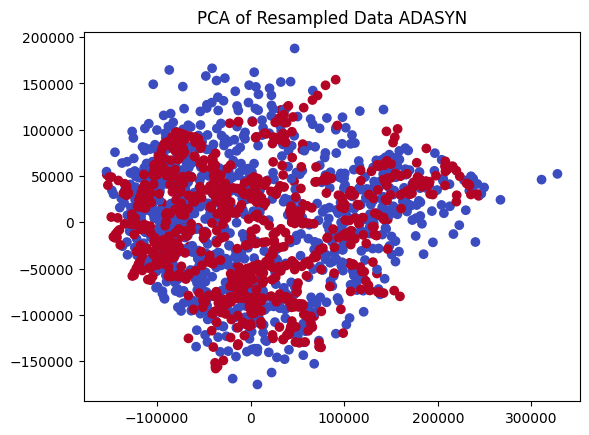

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Plot the PCA results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_resampled, cmap='coolwarm')
plt.title('PCA of Resampled Data ADASYN')
plt.show()


In [41]:
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import TomekLinks

# Split your data into training and testing sets

print('Original dataset shape %s' % Counter(np.squeeze(batch_target, axis=-1)))
# Apply SMOTETomek
smote_tomek = SMOTETomek(smote=SMOTE(), tomek=TomekLinks())
X_resampled, y_resampled = smote_tomek.fit_resample(batch_array.reshape(B, T*H*W*C), batch_target)
print('Resampled dataset shape %s' % Counter(y_resampled))

Original dataset shape Counter({0.0: 908, 1.0: 122})
Resampled dataset shape Counter({0.0: 908, 1.0: 908})


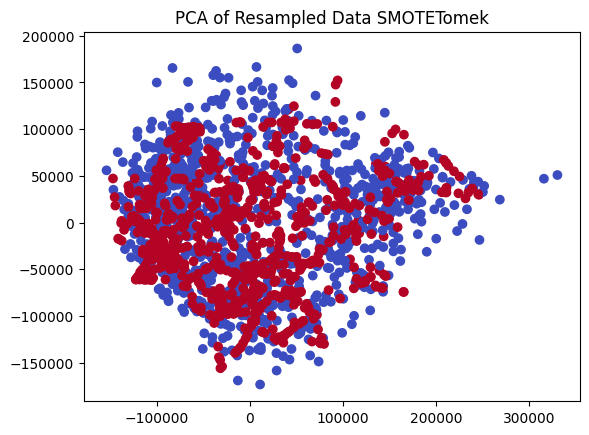

In [42]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_resampled)

# Plot the PCA results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_resampled, cmap='coolwarm')
plt.title('PCA of Resampled Data SMOTETomek')
plt.show()


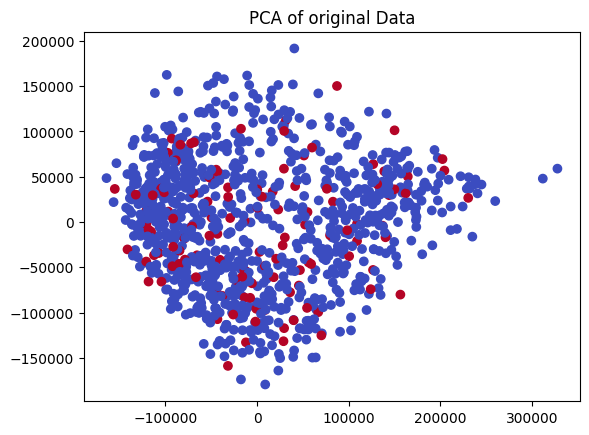

In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# X_resampled = batch_array.reshape(B, T*H*W*C)
# y_resampled = batch_target

# Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(batch_array.reshape(B, T*H*W*C))

# Plot the PCA results
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=batch_target, cmap='coolwarm')
plt.title('PCA of original Data')
plt.show()


In [11]:
## delete the huge numpy array in RAM after processing
del batch_array
del batch_target
del bx
del by

# Pytorch execution

In [14]:
import torch
import torchvision.transforms as transforms

alpha = [1,3,5,7]
degree = [10,15,20,25,30]

transform = A.Compose([
#     A.ElasticTransform(alpha=120, sigma=10, p=0.5),
    A.VerticalFlip(p=0.5),  
    A.GaussianBlur(blur_limit=(random.choice(alpha), random.choice(alpha)), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=random.choice(degree), interpolation=cv2.INTER_LINEAR, p=0.5)
])

class MRIDataset(torch.utils.data.Dataset):
    def __init__(self,  inputs, labels, transform=None):
        self.inputs = inputs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.inputs.shape[0] 

    def __getitem__(self, idx):
        lst=[]
        number_of_sequences = self.inputs[idx].shape[0]
        for i in range(number_of_sequences):
            image = self.inputs[idx][i]
            if np.sum(image)!=0:
                do_transform = random.choice([True, False])
                if self.transform is not None and do_transform:
                    image = self.transform(image=image)['image']
#                     image = image/np.max(image)  ## normalize
                    image = (image-np.min(image))/(np.max(image)-np.min(image))
                else:
#                     image = image/np.max(image)  ## normalize
                    image = (image-np.min(image))/(np.max(image)-np.min(image))
                    
            image = np.expand_dims(image, axis=0) ## 1xHxWx1
            lst.append(image.astype(np.float32))
            
        images = np.concatenate(lst, axis=0) ## 20xHxWx1 --- Numpy array format
        images = np.moveaxis(images, -1, 0)          ## 1x20xHxW --- Torch Tensor format
        label = self.labels[idx].astype(np.float32)
        label = np.expand_dims(label, axis=-1)
        return torch.tensor(images), torch.tensor(label)

In [15]:
def shuffle(images, targets):
    # Set a random seed for reproducibility
    np.random.seed(42)
    # Generate a random permutation of indices
    indices = np.random.permutation(images.shape[0])

    # Shuffle both arrays using the same permutation
    shuffled_images = images[indices]
    shuffled_targets = targets[indices]
    return shuffled_images, shuffled_targets

In [17]:
np.random.seed(42)
# inputs = np.random.rand(1836, 20, 128, 128, 1).astype(np.float32)
# labels = np.random.randint(0, 2, (1836, 1))

inputs = X_resampled.reshape(X_resampled.shape[0], T, H, W, C)
labels = y_resampled
k=0.25
split = round(k*inputs.shape[0])

x, y = shuffle(inputs, labels)

x_train=x[split:]
y_train=y[split:]
x_test=x[:split]
y_test=y[:split]

In [18]:
x.shape, y.shape

((1782, 20, 128, 128, 1), (1782,))

In [19]:
print('number of train samples:', inputs.shape[0]-split)
print('number of test samples:', split)

number of train samples: 1336
number of test samples: 446


In [20]:
batch_size=8

train_dataset = MRIDataset(inputs=x_train, labels=y_train, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

val_dataset = MRIDataset(inputs=x_test, labels=y_test, transform=None)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [22]:
a,b = train_dataset[5]

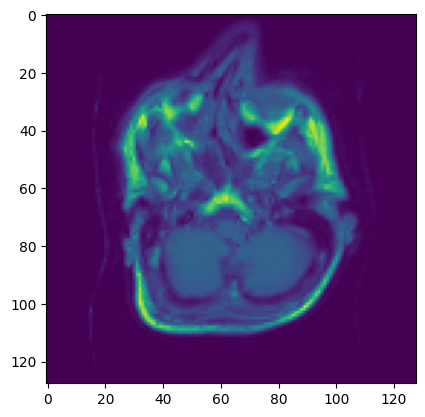

In [23]:
arr = np.moveaxis(a.numpy(), 0, -1)
plt.imshow(arr[0]*255)
plt.show()

In [22]:
bx, by = next(iter(train_loader))

In [23]:
bx.shape, by.shape

(torch.Size([8, 1, 20, 128, 128]), torch.Size([8, 1]))

In [24]:
by

tensor([[0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.]])

In [61]:
torch.max(bx), torch.min(bx)

(tensor(1.), tensor(0.))

In [4]:
root_dir = '/kaggle/input/iaaa-mri-challenge/data/'
ids = glob(root_dir+'*')
files = glob(ids[0]+'/*')

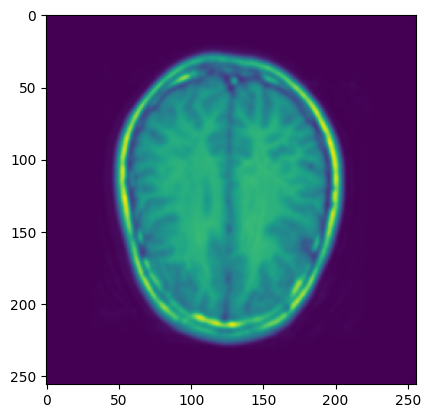

In [120]:
l = [1,3,5,7]

aug = A.Compose([
    A.VerticalFlip(p=0.5),  
    A.GaussianBlur(blur_limit=(random.choice(l), random.choice(l)), p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=-30, interpolation=cv2.INTER_LINEAR, p=0.5)
])

arr = pydicom.dcmread(files[7]).pixel_array
image = aug(image=arr)['image']
plt.imshow(image)

In [98]:
l = [1,3,5,7]
random.choice(l), random.choice(l)

(3, 5)

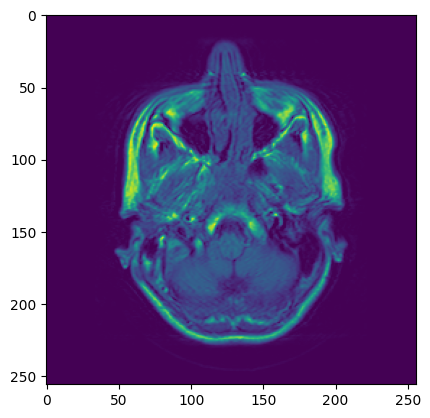

In [9]:
plt.imshow(arr)

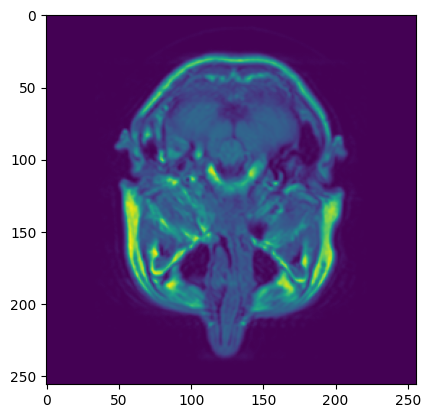

In [14]:
plt.imshow(image)

# *# Model: Training*

In [25]:
import torchvision
import torch
import torch.nn as nn

model = torchvision.models.video.r2plus1d_18(weights=True) ## Prtrained weights downloaded....
model.fc=nn.Linear(512, 1) ## Binary classification---> out_channel=1
model.stem[0]=nn.Conv3d(1, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False) ## gray images --> in_channel=1 
model

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R2Plus1D_18_Weights.KINETICS400_V1`. You can also use `weights=R2Plus1D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth
100%|██████████| 120M/120M [00:00<00:00, 201MB/s] 


VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(1, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [32]:
## (B, T, C, H, W) ---> (B,C,T,H,W)
tensor = torch.rand(3, 1, 20, 128, 128)
model(tensor).shape

torch.Size([3, 98304])

In [29]:
# Remove the last two layers (avgpool and fc)
model.avgpool = torch.nn.Identity()
model.fc = torch.nn.Identity()

In [38]:
out = model.layer4(model.layer3(model.layer2(model.layer1(model.stem(tensor)))))
out.shape

torch.Size([3, 512, 3, 8, 8])

In [ ]:
# train_dataset = MRIDataset(inputs=x_train, labels=y_train, transform=transform)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# test_dataset = MRIDataset(inputs=x_test, labels=y_test, transform=None)
# val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau 
from torch.optim.lr_scheduler import ExponentialLR

from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

'''Initiliziation'''
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002, betas=(0.9, 0.999), eps=1e-8)
# scheduler = ExponentialLR(optimizer, gamma=0.9)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

num_epochs=20


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_metrics = []
val_metrics = []
best_val_f1 = 0.0
save_path = '/kaggle/working/best_model.pt'

print(f'Start Training for {num_epochs} epochs.\n')
print('')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []

    for j, (inputs, labels) in enumerate(train_loader):
        print(f"\rBatch {j}", end="")
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = torch.sigmoid(model(inputs))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        train_preds.extend(outputs.cpu().detach().numpy().flatten())
        train_labels.extend(labels.cpu().detach().numpy())

    ## Convert list to array
    train_preds = np.array(train_preds)
    train_labels = np.array(train_labels)

    train_loss = train_loss / len(train_loader.dataset)
#     train_auc = roc_auc_score(train_labels, train_preds)
    train_precision = precision_score(train_labels, (train_preds > 0.5).astype(int), zero_division=0)
    train_recall = recall_score(train_labels, (train_preds > 0.5).astype(int), zero_division=0)
    train_f1 = f1_score(train_labels, (train_preds > 0.5).astype(int), zero_division=0)
    
    train_metrics.append({
        'loss': train_loss,
#         'auc': train_auc,
        'precision': train_precision,
        'recall': train_recall,
        'F1':train_f1
    })

#     print(f"\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}")
    print(f"\nEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")


    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for j, (inputs, labels) in enumerate(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = torch.sigmoid(model(inputs))
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            val_preds.extend(outputs.cpu().detach().numpy().flatten())
            val_labels.extend(labels.cpu().detach().numpy())

    ## Convert list to array
    val_labels=np.array(val_labels)
    val_preds=np.array(val_preds)

    val_loss = val_loss / len(val_loader.dataset)
#     val_auc = roc_auc_score(val_labels, val_preds)
    val_precision = precision_score(val_labels, (val_preds > 0.5).astype(int), zero_division=0)
    val_recall    = recall_score(val_labels, (val_preds > 0.5).astype(int), zero_division=0)
    val_f1        = f1_score(val_labels, (val_preds > 0.5).astype(int), zero_division=0)
    
    val_metrics.append({
        'loss': val_loss,
#         'auc': val_auc,
        'precision': val_precision,
        'recall': val_recall,
        'F1':val_f1
    })
    
#     scheduler.step(val_loss)

#     print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")
    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f} lr: {scheduler.get_last_lr()[0]}")

    print('===================================================================================================================================')
    print('\n')
    
    scheduler.step(val_loss)
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), save_path)

print('Training Finished...')

Start Training for 20 epochs.


Batch 166
Epoch 1/20, Train Loss: 0.5158, Train Precision: 0.7756, Train Recall: 0.6849, Train F1: 0.7274
Epoch 1/20, Val Loss: 0.8765, Val Precision: 1.0000, Val Recall: 0.4130, Val F1: 0.5846 lr: 0.0002


Batch 166
Epoch 2/20, Train Loss: 0.4547, Train Precision: 0.8103, Train Recall: 0.7598, Train F1: 0.7842
Epoch 2/20, Val Loss: 0.7170, Val Precision: 1.0000, Val Recall: 0.4652, Val F1: 0.6350 lr: 0.0002


Batch 166
Epoch 3/20, Train Loss: 0.3958, Train Precision: 0.8698, Train Recall: 0.7816, Train F1: 0.8233
Epoch 3/20, Val Loss: 0.3557, Val Precision: 0.9882, Val Recall: 0.7261, Val F1: 0.8371 lr: 0.0002


Batch 166
Epoch 4/20, Train Loss: 0.3800, Train Precision: 0.8391, Train Recall: 0.7894, Train F1: 0.8135
Epoch 4/20, Val Loss: 0.8409, Val Precision: 1.0000, Val Recall: 0.4304, Val F1: 0.6018 lr: 0.0002


Batch 166
Epoch 5/20, Train Loss: 0.3817, Train Precision: 0.8660, Train Recall: 0.7863, Train F1: 0.8242
Epoch 5/20, Val Loss: 0.6585, Val 

/tmp/ipykernel_36/2628674179.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, train_losses, 'b', label='Training Loss', color='blue')
/tmp/ipykernel_36/2628674179.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_losses, 'r', label='Validation Loss', color='red')


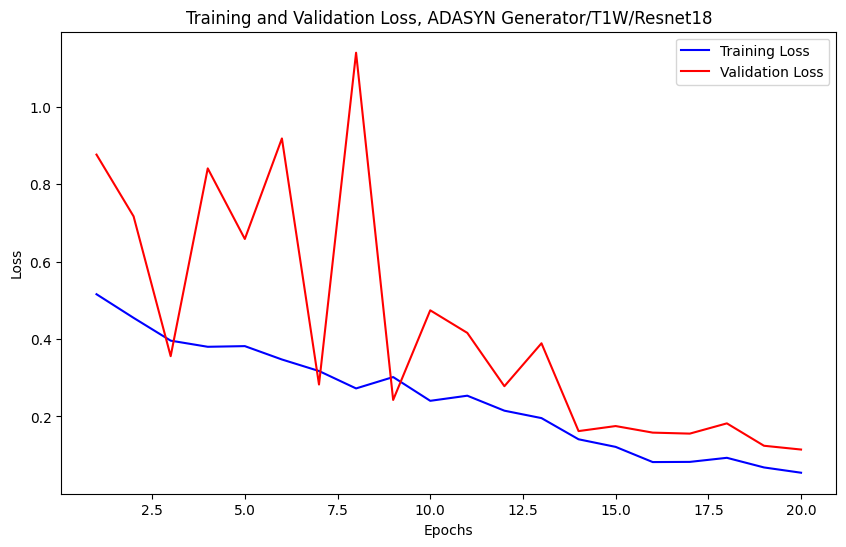

In [34]:
'''model         : resnet18
   data generator: ADASYN
   modality      : T1W_SE'''

train_losses=[]
val_losses=[]

for i in range(len(train_metrics)):
    train_losses.append(train_metrics[i]['loss'])
    val_losses.append(val_metrics[i]['loss'])
    
epochs = range(1, len(train_metrics)+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, 'b', label='Training Loss', color='blue')  
plt.plot(epochs, val_losses, 'r', label='Validation Loss', color='red')  

# Adding titles and labels
plt.title('Training and Validation Loss, ADASYN Generator/T1W/Resnet18')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show plot
plt.show()

/tmp/ipykernel_36/3149796521.py:15: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, f1t, 'b', label='Training Loss', color='blue')
/tmp/ipykernel_36/3149796521.py:16: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r" (-> color=(1.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, f1v, 'r', label='Validation Loss', color='red')


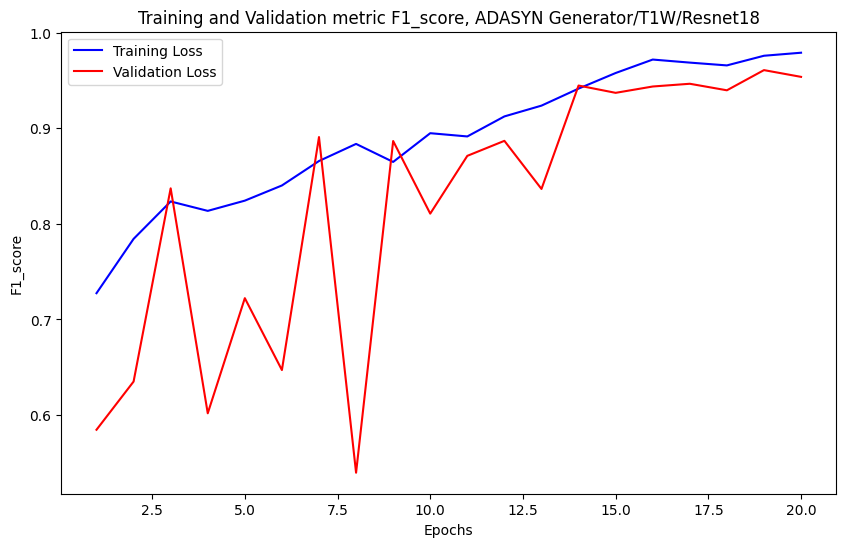

In [35]:
'''model         : resnet18
   data generator: ADASYN
   modality      : T1W_SE'''

f1t=[]
f1v=[]

for i in range(len(train_metrics)):
    f1t.append(train_metrics[i]['F1'])
    f1v.append(val_metrics[i]['F1'])
    
epochs = range(1, len(train_metrics)+1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, f1t, 'b', label='Training Loss', color='blue')  
plt.plot(epochs, f1v, 'r', label='Validation Loss', color='red')  

# Adding titles and labels
plt.title('Training and Validation metric F1_score, ADASYN Generator/T1W/Resnet18')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.legend()

# Show plot
plt.show()

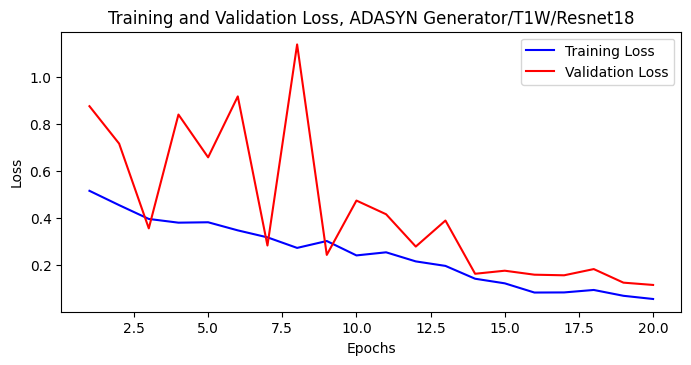

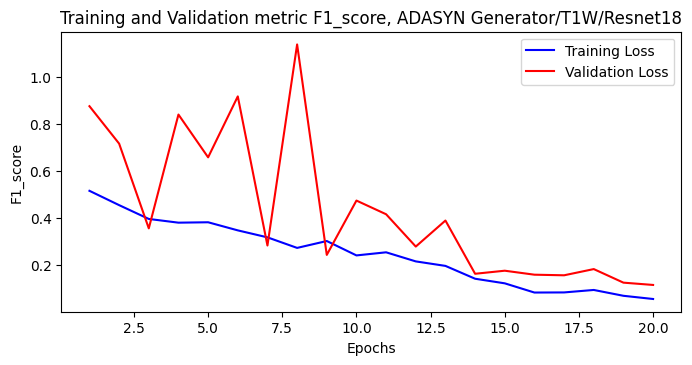

In [39]:
f1t=[]
f1v=[]
train_losses=[]
val_losses=[]


for i in range(len(train_metrics)):
    train_losses.append(train_metrics[i]['loss'])
    val_losses.append(val_metrics[i]['loss'])
    f1t.append(train_metrics[i]['F1'])
    f1v.append(val_metrics[i]['F1'])
    
epochs = range(1, len(train_metrics)+1)


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')  
plt.plot(epochs, val_losses, 'r', label='Validation Loss')  

# Adding titles and labels
plt.title('Training and Validation Loss, ADASYN Generator/T1W/Resnet18')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 2)
plt.plot(epochs, f1t, 'b', label='Training Loss')  
plt.plot(epochs, val_losses, 'r', label='Validation Loss')  

# Adding titles and labels
plt.title('Training and Validation metric F1_score, ADASYN Generator/T1W/Resnet18')
plt.xlabel('Epochs')
plt.ylabel('F1_score')
plt.legend()

# Show plot
plt.show()

